In [14]:
from kafka import KafkaConsumer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from json import dumps
import numpy as np
import pickle
from sklearn.metrics import classification_report,accuracy_score,f1_score
import xgboost as xgb


import pickle


In [15]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

In [16]:
for m in consumer:
        m.value
        break

In [17]:
def get_1000_rec(itr):
    list_of_1000_rec=[]
    i=0
    for c in consumer:

        if i <1000:
            list_of_1000_rec.append(c.value)
            i=i+1
        else:

            break
    print(f"Window {itr}")


    return list_of_1000_rec


In [18]:
col_names =["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]
def adjust_data( data):
    dataframe=pd.DataFrame()
    list_of_rows=[]
    for item in data:
        row_string=eval(item.decode("UTF-8"))
        row_string = row_string.strip()
        row= row_string.split(",")
        list_of_rows.append(row)
    dataframe=pd.DataFrame(list_of_rows)
    dataframe.columns=col_names
    return dataframe

In [19]:
import hashlib

def generate_unique_integer_key(input_string):
    # Use a cryptographic hash function (SHA-256 in this example)
    #print(input_string)
    sha256_hash = hashlib.sha256(input_string.encode()).hexdigest()

    # Convert the hexadecimal hash to an integer
    unique_key = int(sha256_hash, 16)%25
    # print(unique_key)
    # print("#############")
    return unique_key


In [20]:
import numpy
def sigmoid(x):
    return 1 / (1 + numpy.exp(-x))

In [21]:
import datetime

def convert_time(duration_str):
  minutes, seconds = map(float, duration_str.split(":"))

  # Convert to a timedelta
  time_delta = datetime.timedelta(minutes=minutes, seconds=seconds)

  # Convert to rounded hours
  rounded_hours =sigmoid( float(time_delta.total_seconds()))
  return rounded_hours


In [22]:
def cleaning_the_data(data):
    data.dropna(inplace=True)
    data["longest_word"]=data["longest_word"].apply(generate_unique_integer_key)
    data["sld"]=data["sld"].apply(generate_unique_integer_key) 
    data["timestamp"]=data["timestamp"].apply(convert_time)
    

    return data.astype('float')

In [23]:
def retrain(data):

    pipe = Pipeline(steps=[("MI with RF",SelectKBest(score_func=mutual_info_classif, k=9)), ("RandomForestClassifier", RandomForestClassifier(random_state=42,max_depth= None, n_estimators= 100,max_features= 'auto',criterion='gini'))])
    X =data.drop(labels = ["Target Attack"], axis=1)
    y=data["Target Attack"]
    pipe.fit(X,y)
    return pipe

In [24]:
static_model = Dynamic_model= pickle.load(open('mutual_inf_rf_model.pkl', 'rb'))

In [25]:
training_data=cleaning_the_data(adjust_data(get_1000_rec(0)))
list_of_f1_Dynmaic_model=[]
list_of_f1_static_model=[]
for itr in range(1,256):
    r_dataset = get_1000_rec(itr)
    p_dataset =  adjust_data(r_dataset)
    new_dataset =  cleaning_the_data(p_dataset)
    X =new_dataset.drop(labels = ["Target Attack"], axis=1)
    y=new_dataset["Target Attack"]

    Dy_pred=Dynamic_model.predict(X)
    #Dy_pred = [round(value) for value in y_pred_test]
    D_f1=f1_score(y,Dy_pred)
    print(f"The F1 Score of Dynamic Model without retrain = {D_f1*100}%")
    if D_f1 < 0.855 :

        training_data=pd.concat([training_data,new_dataset])
        print(" trained model on the new data")
        Dynamic_model=retrain(training_data)
        Dy_pred=Dynamic_model.predict(X)
        #Dy_pred = [round(value) for value in y_pred_test]
        D_f1=f1_score(y,Dy_pred)
        print(f"The f1 of Dynamic Model after retrain = {D_f1*100}%")
        
    Sy_pred=static_model.predict(X)
    #Sy_pred = [round(value) for value in y_pred_test]
    S_f1=f1_score(y,Sy_pred)
    print(f"The F1 of Static Model = {S_f1*100}%")
    list_of_f1_Dynmaic_model.append(D_f1)
    list_of_f1_static_model.append(S_f1)
    print(f"{'*'*10}")


Window 0
Window 1
The F1 Score of Dynamic Model without retrain = 85.57919621749409%
The F1 of Static Model = 85.57919621749409%
**********
Window 2
The F1 Score of Dynamic Model without retrain = 84.18604651162791%
 trained model on the new data
The f1 of Dynamic Model after retrain = 84.29237947122861%
The F1 of Static Model = 84.18604651162791%
**********
Window 3
The F1 Score of Dynamic Model without retrain = 85.55984555984556%
The F1 of Static Model = 85.97701149425288%
**********
Window 4
The F1 Score of Dynamic Model without retrain = 84.33734939759037%
 trained model on the new data
The f1 of Dynamic Model after retrain = 84.61538461538461%
The F1 of Static Model = 84.52285485164394%
**********
Window 5
The F1 Score of Dynamic Model without retrain = 84.99234303215924%
 trained model on the new data
The f1 of Dynamic Model after retrain = 85.58352402745996%
The F1 of Static Model = 85.6492027334852%
**********
Window 6
The F1 Score of Dynamic Model without retrain = 85.2080123

In [13]:
training_data

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,1.0,13.0,0.0,0.0,12.0,0.0,2.781301,1.0,2.0,10.0,6.000000,5.0,18.0,11.0,0.0,0.0
1,1.0,25.0,8.0,0.0,10.0,9.0,2.786216,6.0,6.0,7.0,3.333333,11.0,16.0,12.0,1.0,0.0
2,1.0,8.0,0.0,0.0,6.0,0.0,2.154135,2.0,2.0,5.0,3.500000,1.0,2.0,6.0,0.0,0.0
3,1.0,20.0,3.0,0.0,18.0,0.0,2.905639,2.0,3.0,12.0,6.000000,2.0,19.0,16.0,1.0,0.0
4,1.0,27.0,10.0,0.0,10.0,11.0,2.767195,6.0,6.0,7.0,3.666667,11.0,16.0,14.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,13.0,0.0,0.0,10.0,2.0,2.989735,1.0,2.0,9.0,6.000000,3.0,1.0,10.0,0.0,0.0
996,1.0,24.0,7.0,0.0,10.0,8.0,2.054029,6.0,6.0,7.0,3.166667,22.0,5.0,11.0,1.0,0.0
997,1.0,11.0,0.0,0.0,10.0,0.0,2.817711,1.0,2.0,8.0,5.000000,16.0,20.0,9.0,0.0,0.0
998,1.0,12.0,0.0,0.0,11.0,0.0,2.514247,1.0,2.0,9.0,5.500000,5.0,6.0,10.0,0.0,0.0


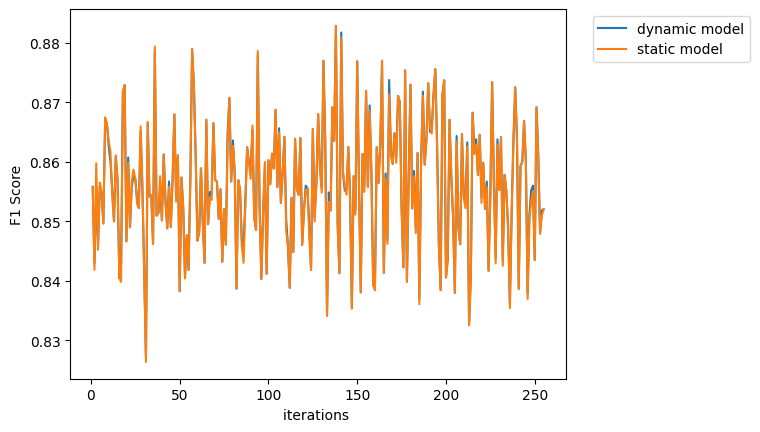

In [26]:
import matplotlib.pyplot as plt
plt.plot(range(1, 256), list_of_f1_Dynmaic_model, label=f'dynamic model')
plt.plot(range(1, 256),list_of_f1_static_model, label=f'static model')
plt.xlabel('iterations ')
plt.ylabel("F1 Score")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")